In [37]:
import bz2
import json
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from itertools import compress
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans

!pip install tld
from tld import get_tld

!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

!pip install empath
from empath import Empath
lexicon = Empath()

In [38]:
from google.colab import drive
drive.mount('/content/drive')
PATH_PROJECT = '/content/drive/MyDrive/ADAproject'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data
Read the data from a specified year into a dataframe. Also, read the stored newspaper list and the parquet file.

In [39]:
YEAR = '2016'
PATH_FILTERED_DATA = f'{PATH_PROJECT}/Data/quotes-{YEAR}.json.bz2'
PATH_OUT = f'{PATH_PROJECT}/Saved_numpy/{YEAR}'
df = pd.read_json(PATH_FILTERED_DATA, compression='bz2', lines=True)

In [40]:
# First time, to create and save a numpy array of newspapers in alphabetical order
first_time = False
if first_time:
    newspapers = {source for sources in df.newspapers for source in sources}
    newspapers = sorted(list(newspapers))
    np.save(f'{PATH_PROJECT}/Saved_numpy/newspapers.npy', newspapers)

# All other times, run this. Load the stored newspapers numpy as a list.
else: 
    newspapers = np.load(f'{PATH_PROJECT}/Saved_numpy/newspapers.npy').tolist()
    nbr_newspapers = len(newspapers)

In [41]:
# Read the parquet file into a dataframe
df_parquet = pd.read_parquet(f'{PATH_PROJECT}/speaker_attributes.parquet')

Based on the dataframe, create two new dataframes with quotes made by conservative and labour politicians.

In [42]:
# Function to retrive a df from df_parquet depending on column [str] and value [str]. column should contain lists
def retrive_df_parquet(column, value):
    not_na = df_parquet.loc[df_parquet[column].dropna().index]
    indices = not_na[not_na[column].map(lambda col_list: value in col_list)].index
    return df_parquet.loc[indices]

# Retrive a new df containing all quotes made by qids_in from df_in
def retrive_qoutes_qids(df_in, qids_in):
    return df_in[df_in.qids.map(lambda qids: any(qid in qids[0] for qid in qids_in))]

In [43]:
parties = ['Q9626', 'Q9630'] # Conservative Party, Labour Party
column = 'party'

parquet_conservative = retrive_df_parquet(column, parties[0]) # The conservative politicians' parquets
qids_conservative = parquet_conservative['id'].tolist() # The qids belonging to the conservative politicans
df_conservative = retrive_qoutes_qids(df, qids_conservative) # All quotes made by conservative politicans this year
nbr_conservative = len(qids_conservative) # number of conservative politicans in the parquet
nbr_conservative_quotes = len(df_conservative) # number of conservative quotes this year

parquet_labour = retrive_df_parquet(column, parties[1])
qids_labour = parquet_labour['id'].tolist()
df_labour = retrive_qoutes_qids(df, qids_labour)
nbr_labour = len(qids_labour)
nbr_labour_quotes = len(df_labour)

#np.save(f'{PATH_OUT}/nbr_conservative_quotes.npy', np.array([nbr_conservative_quotes]))
#np.save(f'{PATH_OUT}/nbr_labour_quotes.npy', np.array([nbr_labour_quotes]))

# Topics matrix
Based on some chosen topics we want to know how many times each newspaper have quotes realted to these. The result is stored as a frequency matrix with newspapers as rows and topics as columns.

In [44]:
# Function to get a dataframe containing only quotes in the newspaper "newspaper"
def get_newspaper_df(df, newspaper):
    return df[df.newspapers.map(lambda news_list: newspaper in news_list)]

# Function to get the number of quotes in the dataframe df containing quotes with atleast one of the keywords in keys
def quotes_containing_keys(df, keys):
    return len(df[df.quotation.map(lambda quotation: any(key in quotation for key in keys))])

In [45]:
# Cell to create key words based on topics
topics = ['climate_change', 'brexit', 'immigration', 'healthcare', 'education', 'war', 'crime', 'monarchy'] # the chosen topics, to be used later 

# Add some example key words to each topic
keywords = {}
keywords['climate_change'] = ['climate_change', 'global_warming', 'carbon_dioxide', 'greenhouse_gas', 'emissions', 'sea_level_rise']
keywords['brexit'] = ['brexit', 'transition_period', 'no_deal']
keywords['immigration'] = ['immigration', 'asylum', 'refugee']
keywords['healthcare'] = ['healthcare', 'public_health']
keywords['education'] = ['education']
keywords['war'] = ['war']
keywords['crime'] = ['crime', 'law_enforcement', 'justice_system']
keywords['monarchy'] = ['Elizabeth', 'royalty', 'the_Queen']

# Use empaths lexicon to create categorical keywords, based on the example key words
for key in keywords.keys():
    lexicon.create_category(key, keywords[key], model="nytimes")
    words = lexicon.cats[key]
    words = [w.replace('_', ' ') for w in words]
    keywords[key] = words

# Add some extra key words 
keywords['brexit'] = keywords['brexit'] + ['brexit', 'no deal', 'Brexit']
keywords['healthcare'] = keywords['healthcare'] + ['NHS']

["greenhouse_gases", "emissions", "carbon_dioxide", "global_warming", "acid_rain", "carbon_dioxide_emissions", "greenhouse_effect", "ozone", "climate_change", "fossil_fuels", "greenhouse_gas_emissions", "chlorofluorocarbons", "air_pollution", "ozone_layer", "ozone_depletion", "gases", "pollutants", "global_climate", "CFC", "emission", "sulfur_dioxide", "smog", "warming", "pollution", "nitrogen_oxides", "global_climate_change", "carbon_emissions", "methane", "depletion", "energy_use", "pollutant", "human_activities", "water_pollution", "environmental_damage", "human_activity", "nuclear_energy", "nitrogen_oxide", "nitrogen", "human_health", "energy_production", "sulfur", "fuels", "hydrocarbons", "other_gases", "deforestation", "nuclear_power", "warming_trend", "sulfur_dioxide_emissions", "auto_emissions", "ecosystems", "climate_system", "other_greenhouse_gases", "oil_spills", "dioxide", "radioactivity", "rising_temperatures", "trapping_gases", "industrialized_countries", "environmental_p

In [46]:
# Create a matrix with the frequencies of each topic, newspaper as row and topic as column  
topics_matrix = np.zeros((nbr_newspapers, len(keywords.keys())))
quotes_per_newspaper = np.zeros(nbr_newspapers)
for row, newspaper in enumerate(newspapers):
    df_newspaper = get_newspaper_df(df, newspaper)
    quotes_per_newspaper[row] = len(df_newspaper)
    for col, key in enumerate(keywords.keys()):
        topics_matrix[row, col] = quotes_containing_keys(df_newspaper, keywords[key])

np.save(f'{PATH_OUT}/topics_matrix.npy', topics_matrix)
np.save(f'{PATH_OUT}/quotes_per_newspaper.npy', quotes_per_newspaper)

# Speakers matrix
Based on the conservative and labour politicans, we want to know how many times each newspapers has quoted them. The result is stored as a matrix of frequencies with newspapers as rows and speakers as columns (conservative speakers: labour speakers).

In [47]:
# Returns a numpy array with the frequencies of the qids in qids_list from df_input. The frequency count are only based on the most likely speaker
def vectorize_quotes_by_qid(df_input, qids_list):
    occurences = [0]*len(qids_list)
    df_qids = df_input[df_input.qids.map(lambda qids: any(qid in qids[0] for qid in qids_list))]
    for i, qid in enumerate(qids_list):
        occurences[i] = df_qids[df_qids.qids.map(lambda qids: qids[0] == qid)]['numOccurrences'].count()
    return occurences

In [ ]:
# Create a matrix with the frequencies of each speaker, newspaper as row and speaker as column
speakers_matrix = np.zeros((nbr_newspapers, nbr_conservative + nbr_labour))
for row, newspaper in enumerate(newspapers):
    df_newspaper = get_newspaper_df(df, newspaper)
    speakers_freq = vectorize_quotes_by_qid(df_newspaper, qids_conservative) # First the conservative speakers
    speakers_freq += vectorize_quotes_by_qid(df_newspaper, qids_labour) # Second the labour speakers
    speakers_matrix[row, :] = speakers_freq
np.save(f'{PATH_OUT}/speakers_matrix.npy', speakers_matrix)

In [ ]:
# Remove speakers that don't have any quotes for each year, save reduced speakers matrices along with speakers kept
years = [2015,2016,2017,2018,2019,2020]

for year in years: 
  speakers_matrix = np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/speakers_matrix.npy')
  nbr_spreakers = speakers_matrix.shape[1]
  non_occuring_speakers = []
  occuring_speakers = []
  for i in range(nbr_spreakers):
    if np.sum(speakers_matrix[:,i]) == 0:
      non_occuring_speakers.append(i)
    else:
      occuring_speakers.append(i)
  speakers_matrix_reduced = np.delete(speakers_matrix, obj=non_occuring_speakers, axis=1)
  np.save(f'{PATH_PROJECT}/Saved_numpy/{year}/speakers_matrix_reduced.npy', speakers_matrix_reduced)
  np.save(f'{PATH_PROJECT}/Saved_numpy/{year}/speakers_indicies.npy', occuring_speakers)
  print(f'{len(non_occuring_speakers)} (of {nbr_spreakers}) don\'t occur in {year}')

# Sentiment matrix
Based on the conservative and labour quotes, we want to know which newspaper that have used the same quotes and which sentiment this quote has. The result is stored as a matrix of sentiment values with newspapers as rows and the quotes as columns (conservative df: labour df).

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Assign categorical values: 1-Positive, 2-Neutral, 3-Negative, to the quote based on thresholds compound_vector. 
def sentiment(quote_in):
    sentiment_value = analyzer.polarity_scores(quote_in)['compound']
    if sentiment_value < -0.5:
        return 3 # Negative
    elif sentiment_value > 0.5:
        return 1 # Positive
    else: 
        return 2 # Neutral

# Returns a sentiment vector based on quote_in, one value for each newspaper in all_newspaper. If the qoute is not qouted in the newspaper it's corresponding value is 0. 
def sentiment_feature_vector(quote_in, quoted_newspapers, all_newspapers):
    sentiment_vector = np.zeros(len(all_newspapers))
    sentiment_value = sentiment(quote_in)
    temp = 1*np.array([x in quoted_newspapers for x in all_newspapers])
    sentiment_vector[temp == 1] = sentiment_value # This row is not working. Vectors are of same size but always assigns value to top 2. TODO
    return sentiment_vector

In [ ]:
# Create a matrix with occurences for each frequency matrix with sentiment
temp_conservative = df_conservative.apply(lambda row: sentiment_feature_vector(row.quotation, row.newspapers, newspapers), axis=1) # Retrive a sentiment matrix for all conservative quotes
temp_conservative = np.concatenate(temp_conservative.to_numpy()) # To get a numpy matrix
temp_conservative = temp_conservative.reshape(nbr_conservative_quotes,nbr_newspapers) # To get the correct shape
temp_labour = df_labour.apply(lambda row: sentiment_feature_vector(row.quotation, row.newspapers, newspapers), axis=1) # Repeat for the labour df
temp_labour = np.concatenate(temp_labour.to_numpy()).reshape(nbr_labour_quotes,nbr_newspapers)
quotes_matrix = np.concatenate((temp_conservative, temp_labour))
quotes_matrix = np.transpose(quotes_matrix)

np.save(f'{PATH_OUT}/quotes_matrix.npy', quotes_matrix)

# Dimensionality reduction and clustering of newspapers

We use the topics, speakers and sentiment matrices created above to do dimensionality reduction and clustering of newspapers.

The dimensionality reduction is done using principal component analysis on so called "feature matrices" which were created above. Each row in that matrix represents a news source and the columns represent features which we imagine could be used to identify and therefore categorize a news source. An example of such a matrix is the speakers where each column represents a specific politician. The values represents how many times a politician has been quoted by a given newspaper. We hypothesize that newspapers which quote the same politicians a given number of times should be similar. By doing PCA on this matrix and clustering the newspapers we hope to be able to identify newspapers which have a similar coverage of certain politicians. 

### Load some helpful functions first!

In [49]:
from sklearn.decomposition import TruncatedSVD, PCA
def standardize(X, rows=False, both=True):
  """
  standardize the feature matrix X, can choose whether to standardize along 
  rows or rows and columns
  """
  if rows:
    X_means = (X.T - np.mean(X, axis=1)).T
    return (X_means.T / np.std(X, axis=1)).T
  elif both:
    X_means = (X.T - np.mean(X, axis=1)).T
    X = (X_means.T / np.std(X, axis=1)).T
    feature_means = np.mean(X, axis=0) # mean for each feature
    feature_std = np.std(X, axis=0)
    return (X - feature_means) / feature_std
  else:
    feature_means = np.mean(X, axis=0) # mean for each feature
    feature_std = np.std(X, axis=0)
    return (X - feature_means) / feature_std

def my_PCA(X, do_standardize=False, sparse=True, ncomp=2):
  """
  Perform PCA on a feature matrix. We can choose if the matrix should be
  standardized, if it should be done on a sparse matrix and the number of 
  components that should be included in the PCA. 
  """
  assert not do_standardize if sparse else True, 'cannot standardize a sparse matrix'
  X = standardize(X) if do_standardize else X
  pca = TruncatedSVD(n_components=ncomp, n_iter=10) if sparse else PCA(n_components=ncomp)
  pca.fit(X)
  return pca

def plot_explained_variance(pca_model, plot_ax=None):  
  """
  Given a PCA model, plot the ratio of the variance that each components 
  explains.
  """
  features = [i + 1 for i in range(pca_model.components_.shape[0])]
  if not plot_ax:
    plot_ax = plt.subplots(1, 1)
  plot_ax.bar(features, pca_model.explained_variance_ratio_, color='black')
  plot_ax.set_xlabel('PCA features')
  plot_ax.set_ylabel('variance %')
  plot_ax.set_title(f'Percentage of the variance that the first {len(features)} components explain')
  plot_ax.set_xticks(features);

def proj_coords(pca, X, do_standardize=False, ncomps=2):
  """
  Project each row-vector in the feature matrix X onto ncomps components taken 
  from the pca-model pca.
  """
  X = standardize(X) if standardize else X
  comps = pca.components_[:ncomps]
  return X @ comps.T

def projected_plot(pca, X, newspaper_list, plot_ax=None, do_standardize=False, print_func=lambda _: True):
  """
  Create the 2D-plot consisting of the coordinates of each row of X projected
  onto the the 2 largest components of the PCA model pca. Some additional
  args are provided to help with plotting. 
  """
  #this will be the projection of each newspaper vector onto the first and second component
  projected = proj_coords(pca, X, do_standardize=do_standardize, ncomps=2)
  newspaper_projections = {paper_name: vec for vec, paper_name in zip(projected, newspaper_list)}
  if not plot_ax:
    plot_ax = plt.subplots(1, 1, figsize=(7, 7))
  plot_ax.scatter(projected[:, 0], projected[:, 1])
  for newspaper, point in newspaper_projections.items():
    pointX, pointY = point
    if print_func(point):
      plot_ax.annotate(newspaper, (pointX, pointY))

def years_tuple(matrix_name):
  """
  Helper function for obtaining numpy arrays for each year given a feature name
  """
  matrix_list = []
  for year in range(2015, 2021):
    matrix_list.append(np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/{matrix_name}.npy'))
  return tuple(matrix_list)


def concatenate_years(matrix_name):
  """
  Concatenate feature matrices over all the years
  """
  return np.hstack(years_tuple(matrix_name))

def sum_years(matrix_name):
  """
  Sum feature matrices over all the years
  """
  matrix_tup = years_tuple(matrix_name)
  total = matrix_tup[0]
  for arr in matrix_tup:
    total += arr
  return total

## PCA on the sentiment matrix
The sentiment is categorical so we don't normalize the feature matrix. The sentiment matrix consists of quotes over the columns and newspapers over the rows. The values consist of values ranging from 1 to 3 where 1 represents a positive quote, 2 a neutral one and 3 a negative quote. By doing PCA over this feature matrix we wish to gain insights over which newspapers use the same quotes. Newspapers which use the same quotes should be more similar

We first load the data over all the years, do the PCA with 10 components and then look at how much of the variance is explained by each component

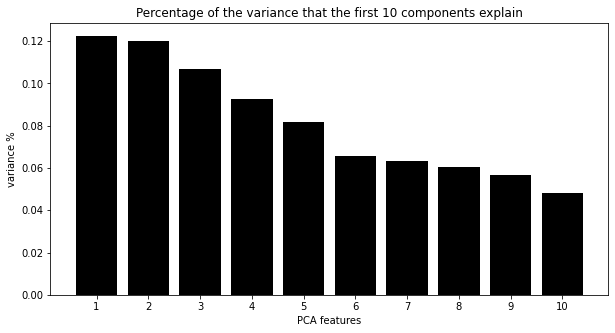

In [50]:
newspaper_list = np.load(f'{PATH_PROJECT}/Saved_numpy/newspapers.npy')
sentiment_matrix = concatenate_years('quotes_matrix')
sentiment_pca_no_std = my_PCA(sentiment_matrix, do_standardize=False, sparse=False, ncomp=10)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_explained_variance(sentiment_pca_no_std, plot_ax=ax);

To visualize the newspapers based on the sentiment score of their quotes we can project the "sentiment-vector" of each newspaper onto the two components which explain the variance the best. We then get the following plot

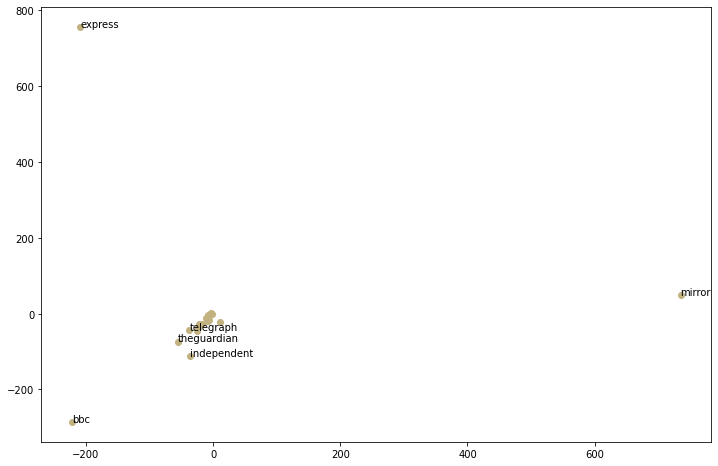

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
projected_plot(sentiment_pca_no_std, sentiment_matrix, newspaper_list, plot_ax=ax, do_standardize=False, print_func=lambda p: p@p > 3e3)

From the plot it seems like BBC, The Daily Express and the Mirror stand apart from the rest of the newspapers when it comes to their quotes. We haven't been able to find in what way this is though. One thing to note is that two components only explain around 25 % of the variance. It could be that if we projected the newspapers onto different components we would not the same clustering. 

## PCA on the topics matrix

The topics matrix is standardized over both columns and vectors before doing a PCA on it. Again plot the percentage of the variance that is explained by the first 8 components (the max number of components since we have 8 topics that we look at). Here we thought that news sources that use topics which are similar should be clustered together.  

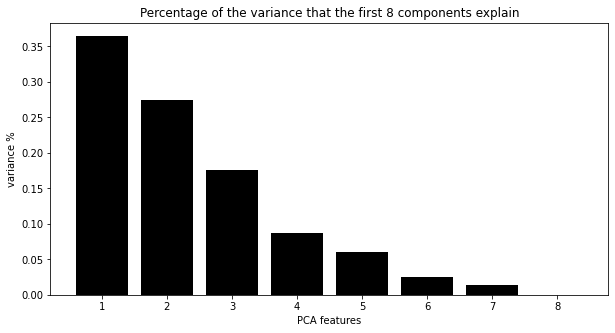

In [52]:
newspaper_list = np.load(f'{PATH_PROJECT}/Saved_numpy/newspapers.npy')
topics_matrix = sum_years('topics_matrix')
topics_pca = my_PCA(topics_matrix, do_standardize=True, sparse=False, ncomp=8)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_explained_variance(topics_pca, plot_ax=ax);

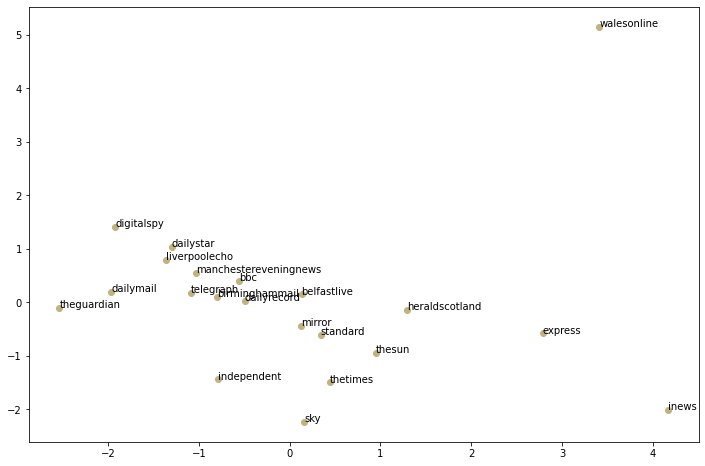

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
projected_plot(topics_pca, topics_matrix, newspaper_list, plot_ax=ax, do_standardize=False, print_func=lambda p: True)

It's hard to draw any conclusions from the plot since there doesn't exist any clear clusters. 

## PCA on the speakers matrix

Due to the way that the way that the speakers matrix is created we cannot run PCA on all the years. We choose the year 2017 and do PCA on that. This time we do the PCA both with and without standardization of the feature matrix. 

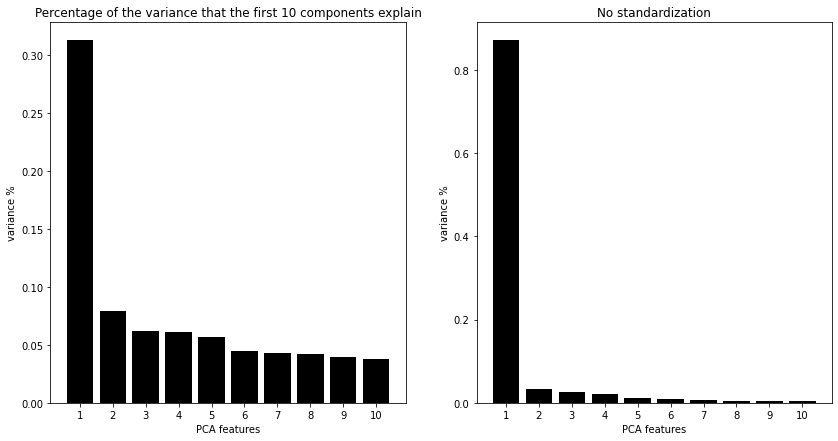

In [54]:
year = 2018
newspaper_list = np.load(f'{PATH_PROJECT}/Saved_numpy/newspapers.npy')
speakers_matrix = np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/speakers_matrix_reduced.npy')
speakers_pca = my_PCA(speakers_matrix, do_standardize=True, sparse=False, ncomp=10)
speakers_pca_no_std = my_PCA(speakers_matrix, do_standardize=False, sparse=False, ncomp=10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_explained_variance(speakers_pca, plot_ax=ax1)
plot_explained_variance(speakers_pca_no_std, plot_ax=ax2)
ax2.set_title('No standardization');

Here we see that just one component explains the variance quite well.

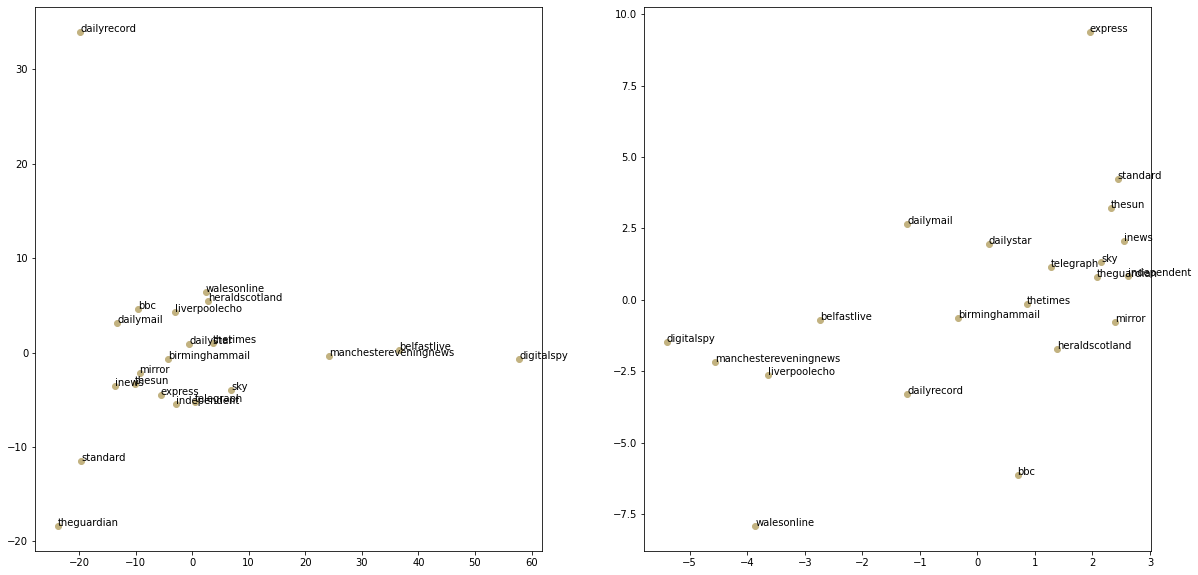

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
projected_plot(speakers_pca, speakers_matrix, newspaper_list, plot_ax=ax1, do_standardize=True, print_func=lambda p: True)
projected_plot(speakers_pca_no_std, speakers_matrix, newspaper_list, plot_ax=ax2, do_standardize=False, print_func=lambda p: True)

It's hard to find any clusters here aswell even though the variance is well explained by the two components which are projected upon. 

We have now done PCA on newspapers for all years for topics and sentiment. For speakers we did it for one specific year. Now try out PCA for each year and animate it as the years change. 

#Clustering and animation of PCA over the years.

#### First load functions

In [58]:
def find_threshold_index(ratios, threshold):
  """
  Given a list of values, calculate the cumulative sum and return the first 
  index which is larger than the threshold
  """
  return len([ratio for ratio in np.cumsum(ratios) if ratio < threshold])

def create_labels(feature_matrix, pca, explained_variance_threshold=0.75):
  """
  Create cluster labels for each news source in the feature_matrix based on 
  KMeans clustering of the coordinates which are given by projecting onto
  the components which explain 75 or more percent of the variance
  """
  ncomp = find_threshold_index(pca.explained_variance_ratio_, explained_variance_threshold) + 1
  print(f'number of components chosen when clustering: {ncomp}')
  projected = proj_coords(pca, feature_matrix, do_standardize=False, ncomps=ncomp)
  return clustering(projected)

def clustering(reduced_matrix, k=2):
  """
  helper method for KMeans clustering of reduced_matrix
  """
  label_list = KMeans(n_clusters=k, random_state=10, init='k-means++', n_init=30).fit_predict(reduced_matrix)
  return label_list

def create_df(matrix_name, newspaper_list):
  """
  Create dataframe which is used for animating the newspapers' reduced 
  representations over every year. 
  """
  data = []
  for year in range(2015, 2021):
    feature_matrix = np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/{matrix_name}.npy')
    max_ncomps = min(feature_matrix.shape)
    print(f'{feature_matrix.shape}')
    pca = my_PCA(feature_matrix, do_standardize=True, sparse=False, ncomp=max_ncomps)
    pca_no_std = my_PCA(feature_matrix, do_standardize=False, sparse=False, ncomp=max_ncomps)
    projected = proj_coords(pca, feature_matrix, do_standardize=False, ncomps=2)
    projected_no_pcs = proj_coords(pca_no_std, feature_matrix, do_standardize=False, ncomps=2)
    label_list = create_labels(feature_matrix, pca)
    label_list_no_pca = create_labels(feature_matrix, pca_no_std)
    for i, (comps, label) in enumerate(zip(projected, label_list)):
      news_name = newspaper_list[i]
      if news_name in {'bbc', 'independent'}:
        political = 'neutral'
      elif news_name in {'mirror', 'theguardian'}:
        political = 'left'
      elif news_name in {'dailymail', 'express', 'thesun', 'telegraph', 'thetimes'}:
        political = 'right'
      else:
        political = 'idk'
      data.append((newspapers_list[i], year, comps[0], comps[1], 'yes', 10, label, political))
    for i, (comps, label) in enumerate(zip(projected_no_pcs, label_list)):
      data.append((newspapers_list[i], year, comps[0], comps[1], 'no', 10, label))
  return pd.DataFrame(data, columns=['newssource', 'year', 'x', 'y', 'standardized', 'size', 'label', 'political_stance'])


#### Then load the data and animate

We can choose which features we want to use and PCA is then performed for each year on that feature. The data is projected onto the two largest componensts and animated over the years. Here we do the PCA and clustering on speakers matrix

Unfortunately we were not able to anything interesting from these plots or the clusterings. 

In [60]:
feature_matrix = 'speakers_matrix_reduced'
newspapers_list = np.load(f'{PATH_PROJECT}/Saved_numpy/newspapers.npy')
pca_df = create_df(feature_matrix, newspapers_list)

(21, 1127)
number of components chosen when clustering: 9
number of components chosen when clustering: 1
(21, 949)
number of components chosen when clustering: 10
number of components chosen when clustering: 2
(21, 1096)
number of components chosen when clustering: 10
number of components chosen when clustering: 1
(21, 1127)
number of components chosen when clustering: 10
number of components chosen when clustering: 1
(21, 1097)
number of components chosen when clustering: 9
number of components chosen when clustering: 1
(21, 674)
number of components chosen when clustering: 10
number of components chosen when clustering: 1


In [61]:
plot_df = pca_df[pca_df.standardized == 'yes']

fig = px.scatter(plot_df, x='x', y='y', animation_frame='year', animation_group='newssource',
                color='political_stance', hover_name='newssource', size='size', color_discrete_sequence=['#808080', '#964B00', '#1F3050', '#ED2939'])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.update_layout(xaxis_range=[plot_df.x.min(),plot_df.x.max()], yaxis_range=[plot_df.y.min(),plot_df.y.max()])
#fig.write_html(f'{PATH_PROJECT}/anton/ploty_scatter.html')
fig.show()

# Plots and animations

In [62]:
# To be used for most analysis
years = [2015,2016,2017,2018,2019,2020]
colors = ['#C2B280','#634739', '#70360E', '#935D23', '#B68337', '#D9AA4C', '#FCD060'] 
sns.set_palette(sns.color_palette(colors))

## Heat map for topics

Here we investigate how often given newspapers cover a given topic and visualize it using a heatmap. 

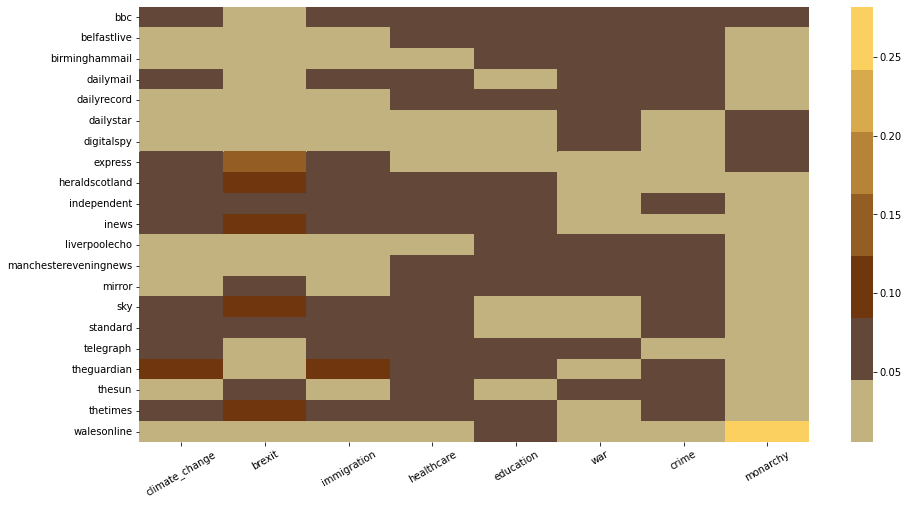

In [63]:
# Use the mean of the topics occurence over the years
topics_matrix_sum = np.zeros((len(newspapers), len(topics)))
for year in years: 
  topics_matrix = np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/topics_matrix.npy')
  topics_matrix_sum += topics_matrix
topics_matrix_mean = topics_matrix_sum/len(years)  

# Normalize topic matrix per row and column, so we get percentage for each newspaper??
row_sums = topics_matrix_mean.sum(axis=1)
topics_matrix_mean = topics_matrix_mean / row_sums[:, np.newaxis]
column_sums = topics_matrix_mean.sum(axis=0)
topics_matrix_mean = topics_matrix_mean / column_sums[np.newaxis, :]

plt.figure(figsize=(15,8))
ax = sns.heatmap(topics_matrix_mean, xticklabels=topics, yticklabels=newspapers, cmap=colors)#, norm=LogNorm()) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);
#plt.savefig(f'{PATH_PROJECT}/Plots/heatmap_normalized.png')

## Pie graph of the total amount of quotes summed over all years on a newspaper level

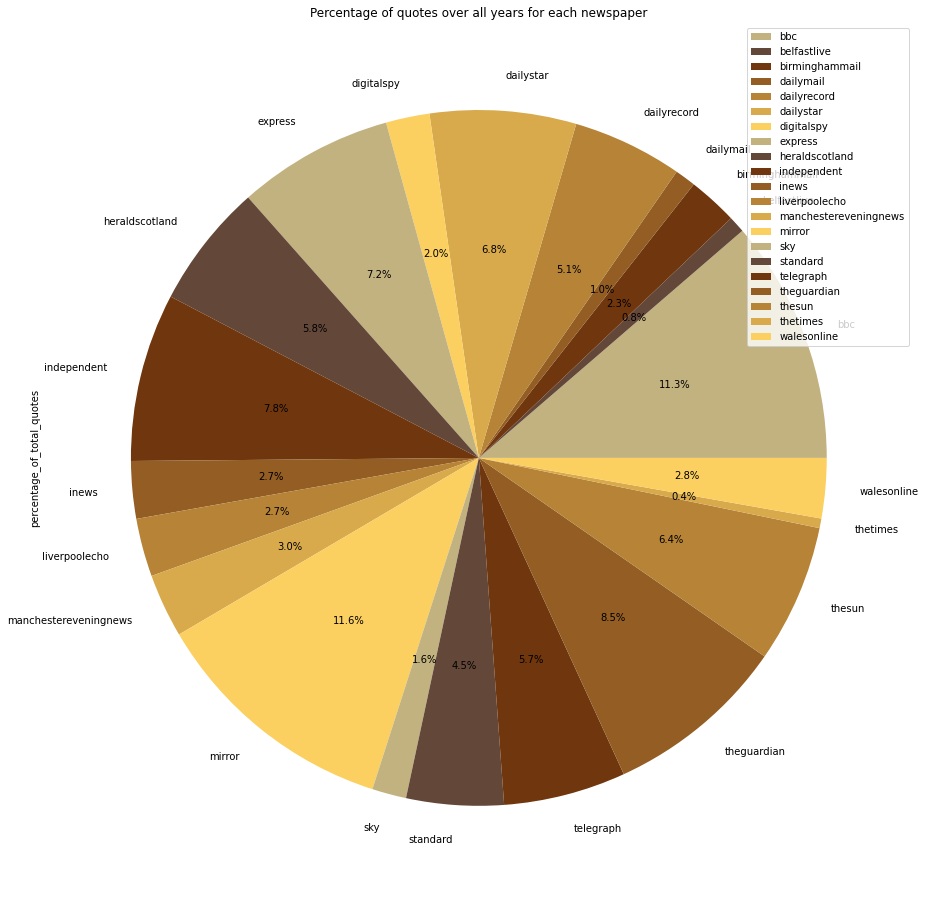

In [64]:
quotes_per_newspaper = np.zeros((len(newspapers),))
# Sum the number of quotes from all years
for year in years:
  quotes_per_newspaper += np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/quotes_per_newspaper.npy')

summed_quotes = pd.DataFrame({'percentage_of_total_quotes': quotes_per_newspaper}, index=newspapers)
plot = summed_quotes.plot.pie(y='percentage_of_total_quotes', figsize=(16, 16), autopct='%1.1f%%', title = 'Percentage of quotes over all years for each newspaper')
fig = plot.get_figure()
#fig.savefig(f'{PATH_PROJECT}/Plots/pie_quotes_all_years.png')

## Histogram of negative, positive and neutral quotes

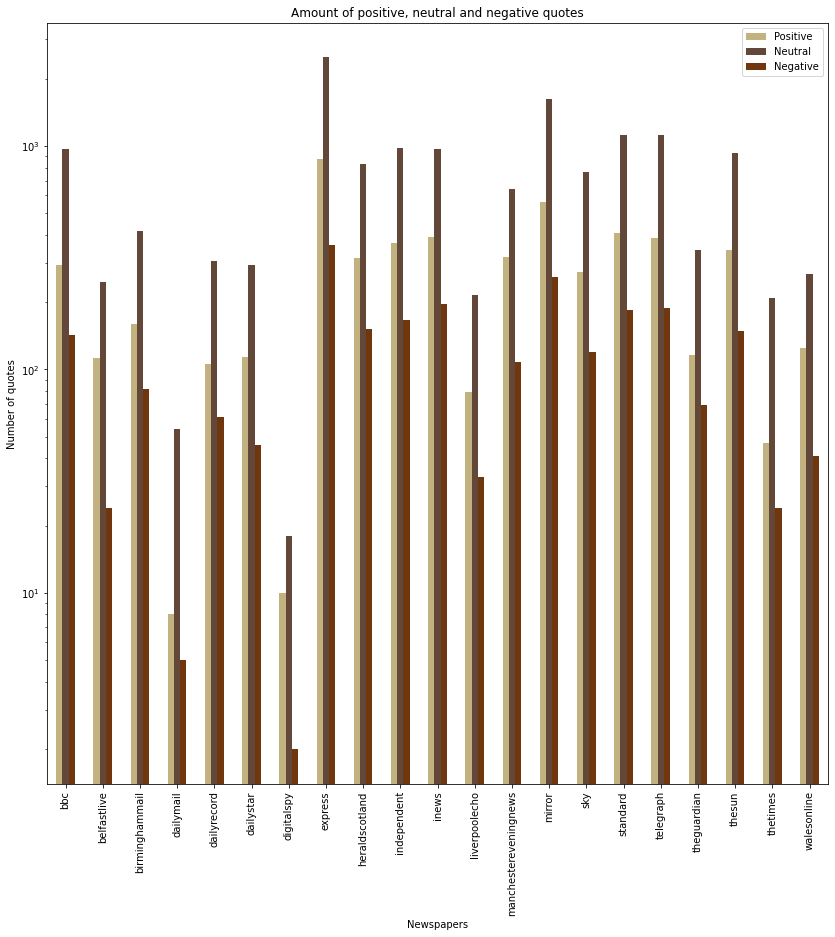

In [65]:
sentiment_sum = np.zeros((len(newspapers), 4))
# Sum the number of quotes from all years
for year in years:
  quotes_matrix = np.load(f'{PATH_PROJECT}/Saved_numpy/{year}/quotes_matrix.npy').astype(int)
  for i in range(len(newspapers)):
      temp = np.bincount(quotes_matrix[i, :])
      sentiment_sum[i, 0:len(temp)] = temp

sentiment_sum = sentiment_sum.astype(int)
temp = pd.DataFrame(sentiment_sum[:, 1:4], index = newspapers)
plot = temp.plot.bar(figsize=(14, 14), logy=True)  # log increases visability
plt.legend(["Positive", "Neutral", "Negative"]);
plt.ylabel('Number of quotes')
plt.xlabel('Newspapers')
plt.title('Amount of positive, neutral and negative quotes')
fig = plot.get_figure()
#fig.savefig(f'{PATH_PROJECT}/Plots/hist_sentiment_all_years.png')

## Animation for number of quotes and mean sentiment for each party for every newspaper

In [66]:
# This cell is run once for each year. The resulting data frames are stored. 
first_time = False
if first_time:
  df_sums = pd.DataFrame(columns = ['year','newspaper','number of quotes', 'party', 'mean sentiment'])
  df_conservative_exploded = df_conservative.explode('newspapers').reset_index()
  df_labour_exploded = df_labour.explode('newspapers').reset_index()

  index = 0
  for newspaper in newspapers:
    for i in range(2): # two parties
      df_sums.at[index, 'newspaper'] = newspaper
      df_sums.at[index, 'year'] = YEAR
      if i == 0: 
        df_sums.at[index, 'party'] = 'conservative'
        # Get quotes made by conservative speakers  
        indicies = df_conservative_exploded[df_conservative_exploded['newspapers'] == newspaper].index
        quotes = df_conservative_exploded.loc[indicies, 'quotation']
      else: 
        df_sums.at[index, 'party'] = 'labour'
        # Get quotes made by labour speakers   
        indicies = df_labour_exploded[df_labour_exploded['newspapers'] == newspaper].index
        quotes = df_labour_exploded.loc[indicies, 'quotation']
      
      df_sums.at[index, 'number of quotes'] = len(quotes)
      # Compute mean sentiment and add to dataframe 
      sum_sentiment = 0
      for quote in quotes:
        sum_sentiment += sentiment(quote)
      mean_sentiment = sum_sentiment / len(quotes)
      df_sums.at[index,'mean sentiment'] = mean_sentiment
      index += 1
  df_sums.to_csv(f'{PATH_OUT}/df_sums.csv', index=False)
  df_sums.head()

In [67]:
# Import the dataframes created and stored by above code, merge them into one. 
df_sums_allyears = pd.DataFrame(columns = ['year','newspaper','number of quotes', 'party', 'mean sentiment'])
for year in years:
  df_sums = pd.read_csv(f'{PATH_PROJECT}/Saved_numpy/{year}/df_sums.csv')
  df_sums_allyears = pd.concat([df_sums_allyears, df_sums], ignore_index=True)
df_sums_allyears.sample(5)

,year,newspaper,number of quotes,party,mean sentiment
77,2016,theguardian,826,labour,1.927361
233,2020,liverpoolecho,119,labour,1.815126
154,2018,sky,2043,conservative,1.922173
18,2015,independent,2411,conservative,1.924513
152,2018,mirror,7243,conservative,1.919094


In [68]:
fig = px.bar(df_sums_allyears, x='newspaper', y='number of quotes', 
             color='party', barmode='group', animation_frame= 'year', log_y=True, color_discrete_sequence = ['#C2B280', '#634739'])
fig.write_html(f'{PATH_PROJECT}/Plots/animation_quotesperparty.html')
fig.show()

In [69]:
fig = px.bar(df_sums_allyears, x='newspaper', y='mean sentiment', 
             color='party', barmode='group', animation_frame= 'year', color_discrete_sequence = ['#C2B280', '#634739'])
fig.write_html(f'{PATH_PROJECT}/Plots/animation_sentimentperparty.html')
fig.show()

# Pie graph for how brittons get their news

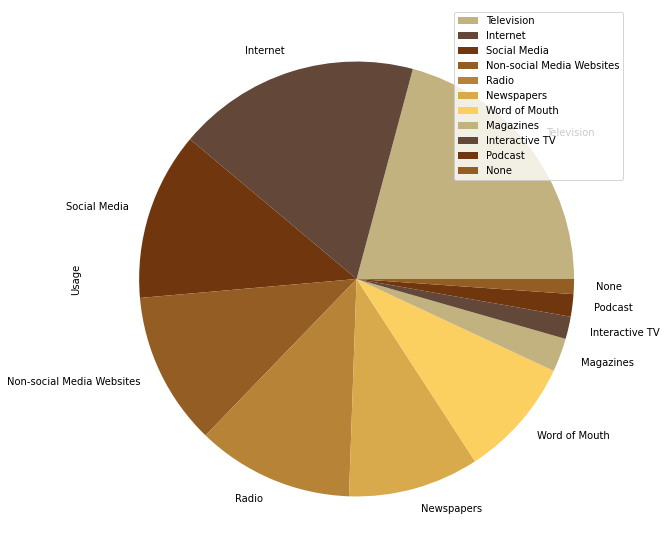

In [70]:
platforms = pd.DataFrame({'Usage': [75, 65 , 45, 41, 42, 35, 32, 9, 6, 6, 4]},
                  index=['Television', 'Internet', 'Social Media', 'Non-social Media Websites', 'Radio', 'Newspapers', 'Word of Mouth', 'Magazines', 'Interactive TV', 'Podcast', 'None'])
plot = platforms.plot.pie(y='Usage', figsize=(10, 10))
fig = plot.get_figure()
#fig.savefig('News Platform Usage UK 2020.png') 

# How left or right are UK newspapers according to yougov survey

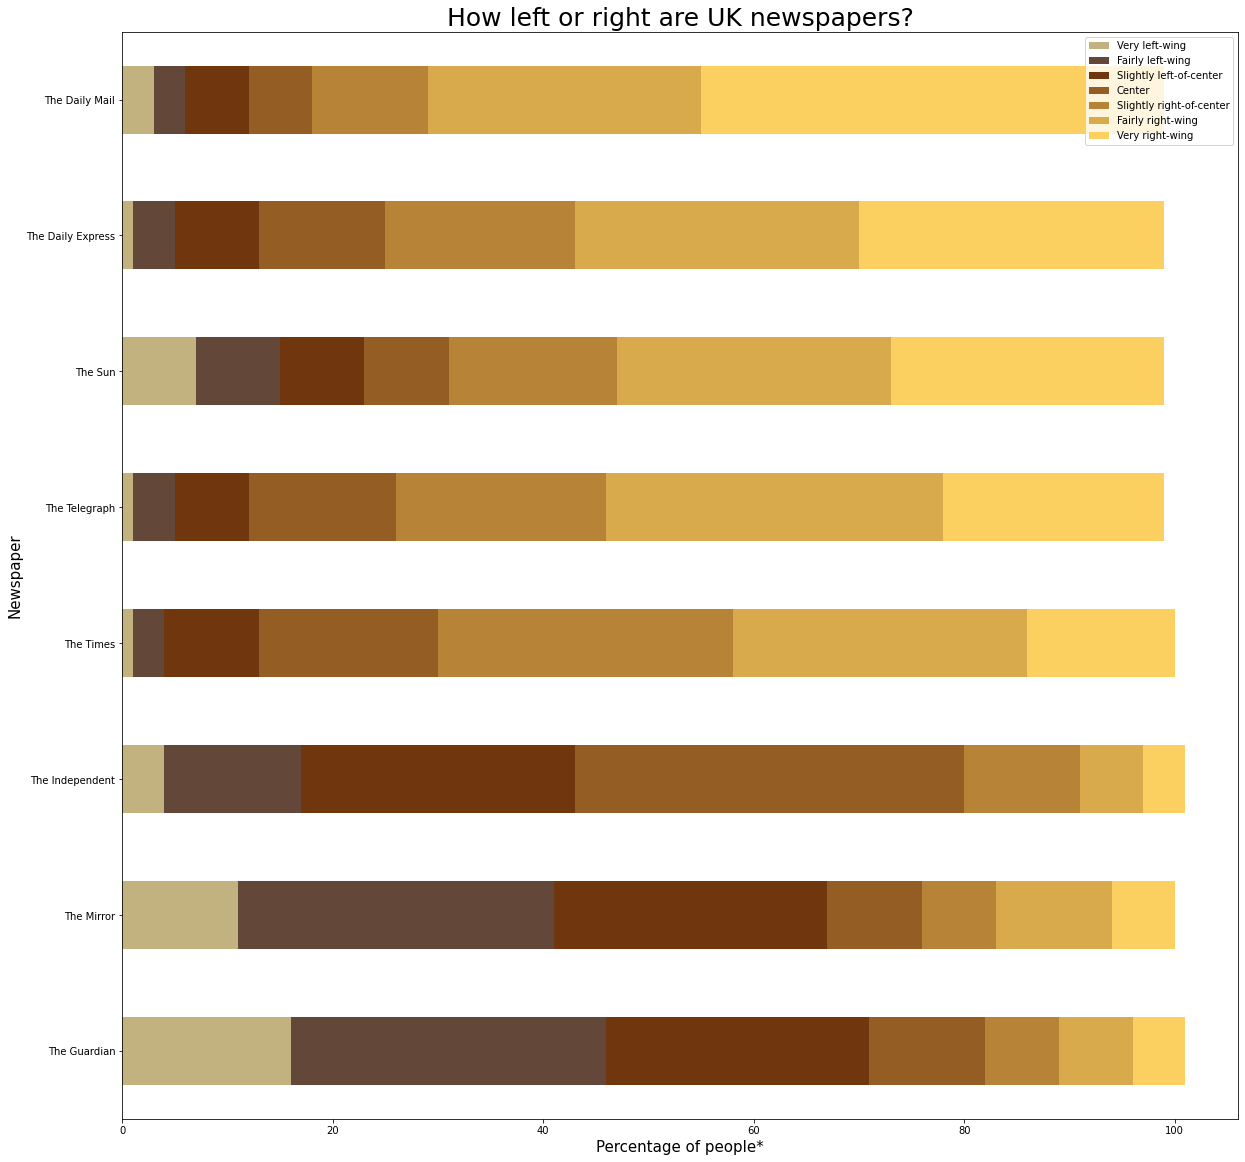

In [71]:
yougov = pd.DataFrame({'Very left-wing': [16, 11, 4, 1, 1, 7, 1, 3],'Fairly left-wing': [30, 30, 13, 3, 4, 8, 4, 3],'Slightly left-of-center':[25,26,26,9,7,8,8,6],'Center':[11, 9, 37, 17, 14, 8, 12, 6],'Slightly right-of-center':[7,7,11,28,20,16,18,11],'Fairly right-wing':[7,11,6,28,32,26,27,26], 'Very right-wing':[5,6,4,14,21,26,29,44]},
                  index=['The Guardian', 'The Mirror', 'The Independent', 'The Times', 'The Telegraph', 'The Sun', 'The Daily Express', 'The Daily Mail'])
p = yougov.plot(
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    figsize=(20,20))
#for c in p.containers:
#    p.bar_label(c, label_type='center')
p.set_title('How left or right are UK newspapers?', fontsize=25)
p.set_xlabel('Percentage of people*', fontsize=15)
p.set_ylabel('Newspaper', fontsize=15);